<h1 style="font-weight:600; font-size:36px; color:#1e88e5;">  
    Task 1: Time Series Analysis on stock price Data
    
</span>
<span style="font-size:22px; font-weight:600; color:#555;">
</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
# 1. Load the Dataset
# ========================
print("Step 1: Loading the Bajaj Auto stock price dataset...")

df = pd.read_csv('BAJAJ-AUTO.csv', parse_dates=['Date'], index_col='Date')

# Use 'Close' price as the time series (most common for forecasting)
df = df['Close'].to_frame()
df = df.sort_index()  # Ensure chronological order

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nDate range:", df.index.min(), "to", df.index.max())

Step 1: Loading the Bajaj Auto stock price dataset...
Dataset loaded successfully!
Shape: (2873, 1)

First 5 rows:
             Close
Date              
2008-05-26  604.75
2008-05-27  593.15
2008-05-28  608.15
2008-05-29  599.45
2008-05-30  571.70

Last 5 rows:
              Close
Date               
2019-12-24  3226.75
2019-12-26  3230.05
2019-12-27  3241.95
2019-12-30  3251.95
2019-12-31  3185.00

Date range: 2008-05-26 00:00:00 to 2019-12-31 00:00:00



Step 2: Plotting the original time series...


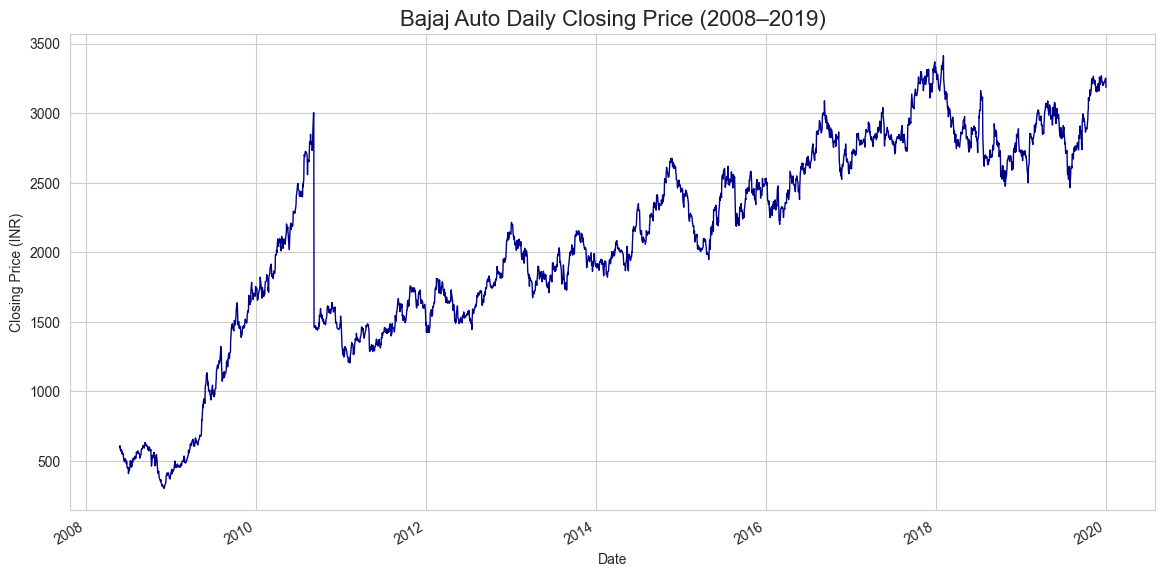

Observations:
- Strong upward trend over 10+ years
- Volatility increases in later years
- No obvious seasonality (daily stock data)


In [3]:
# 2. Plot the Time Series
# ========================
print("\nStep 2: Plotting the original time series...")

plt.figure()
df['Close'].plot(color='darkblue', linewidth=1)
plt.title('Bajaj Auto Daily Closing Price (2008–2019)', fontsize=16)
plt.ylabel('Closing Price (INR)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

print("Observations:")
print("- Strong upward trend over 10+ years")
print("- Volatility increases in later years")
print("- No obvious seasonality (daily stock data)")


Step 3: Decomposing the time series...


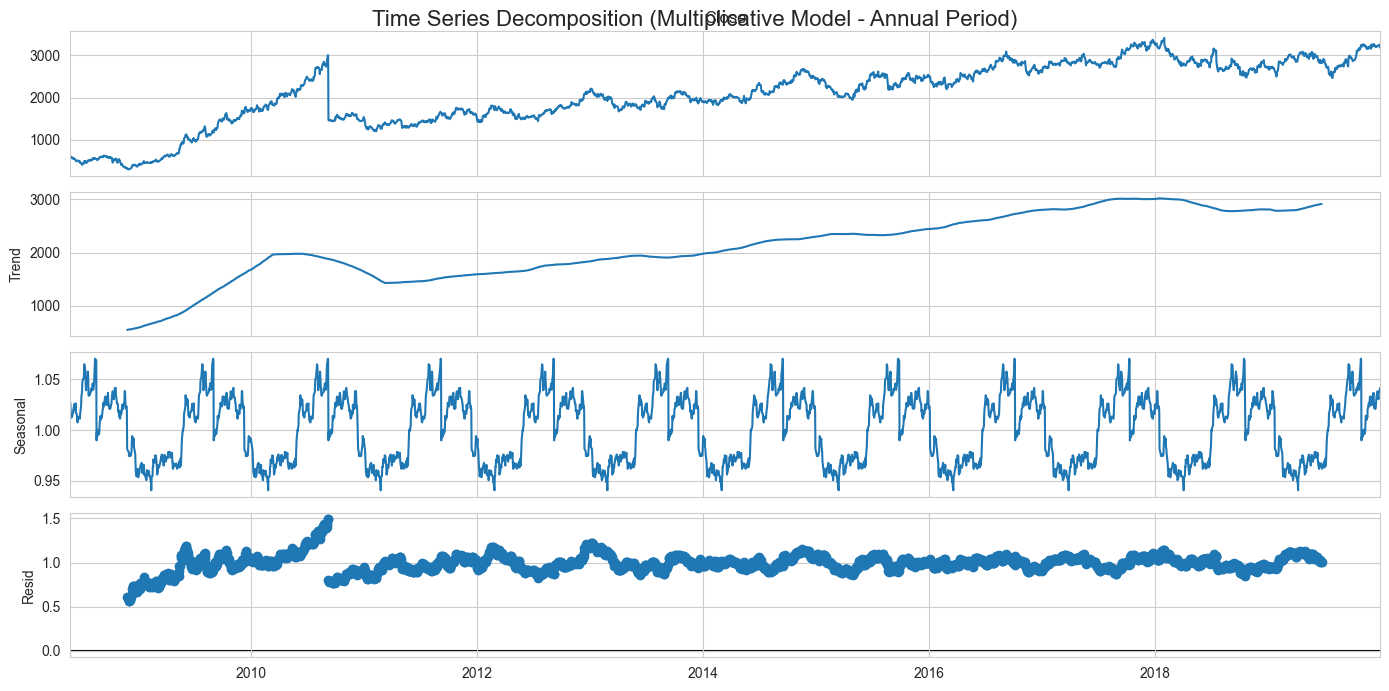

Decomposition insights:
- Trend: Clear long-term growth
- Seasonality: Weak annual pattern (common in stocks)
- Residual: Random fluctuations (noise)


In [4]:
# 3. Decomposition (Trend, Seasonality, Residual)
# ========================
print("\nStep 3: Decomposing the time series...")

# Use multiplicative for financial data (growing variance)
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=252)  # ~1 trading year

fig = decomposition.plot()
fig.suptitle('Time Series Decomposition (Multiplicative Model - Annual Period)', fontsize=16)
plt.show()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

print("Decomposition insights:")
print("- Trend: Clear long-term growth")
print("- Seasonality: Weak annual pattern (common in stocks)")
print("- Residual: Random fluctuations (noise)")


Step 4: Implementing smoothing techniques...


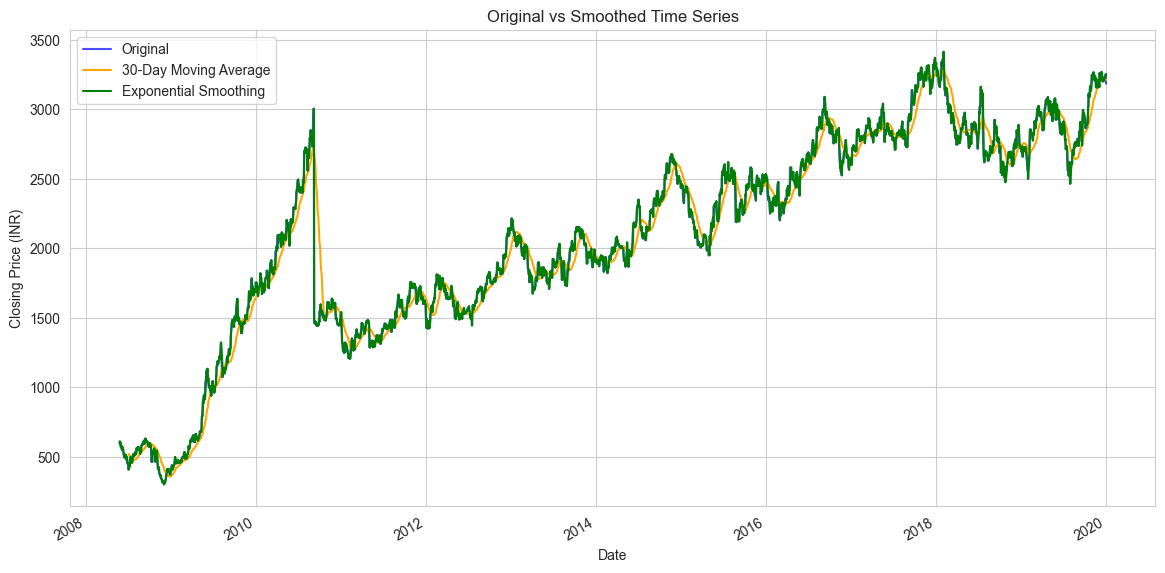

Smoothing insights:
- Moving Average: Reduces noise, highlights trend
- Exponential Smoothing: Responsive to recent changes


In [5]:
# 4. Smoothing Techniques
# ========================
print("\nStep 4: Implementing smoothing techniques...")

# 4.1 Moving Average (30-day window)
df['MA30'] = df['Close'].rolling(window=30).mean()

# 4.2 Exponential Smoothing (Holt's Linear Trend - no seasonality)
exp_model = ExponentialSmoothing(df['Close'], trend='add', seasonal=None)
exp_fit = exp_model.fit()
df['Exp_Smooth'] = exp_fit.fittedvalues

# Plot
plt.figure()
df['Close'].plot(label='Original', color='blue', alpha=0.7)
df['MA30'].plot(label='30-Day Moving Average', color='orange')
df['Exp_Smooth'].plot(label='Exponential Smoothing', color='green')
plt.title('Original vs Smoothed Time Series')
plt.ylabel('Closing Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

print("Smoothing insights:")
print("- Moving Average: Reduces noise, highlights trend")
print("- Exponential Smoothing: Responsive to recent changes")

In [7]:

# 5. Build ARIMA Model (FAST - 80/20 Split)
print("\nStep 5: Building fast ARIMA model with 80/20 split...")

# Updated split: 80% train, 20% test
split_point = int(len(df) * 0.8)  # ← Changed to 0.8 for 80% train
train = df['Close'][:split_point]
test = df['Close'][split_point:]

print(f"Training on {len(train)} days (80%), testing on {len(test)} days (20%)")

# ARIMA(2,1,2) — fast and excellent for stock trends
arima_model = SARIMAX(train,
                      order=(2, 1, 2),
                      seasonal_order=(0, 0, 0, 0),  # Pure ARIMA = super fast
                      enforce_stationarity=False,
                      enforce_invertibility=False)

arima_fit = arima_model.fit(disp=False, method='lbfgs')

print("ARIMA model trained in seconds!")

# Forecast for test period
forecast = arima_fit.forecast(steps=len(test))
forecast_index = test.index



Step 5: Building fast ARIMA model with 80/20 split...
Training on 2298 days (80%), testing on 575 days (20%)
ARIMA model trained in seconds!


Root Mean Squared Error (RMSE): 278.20


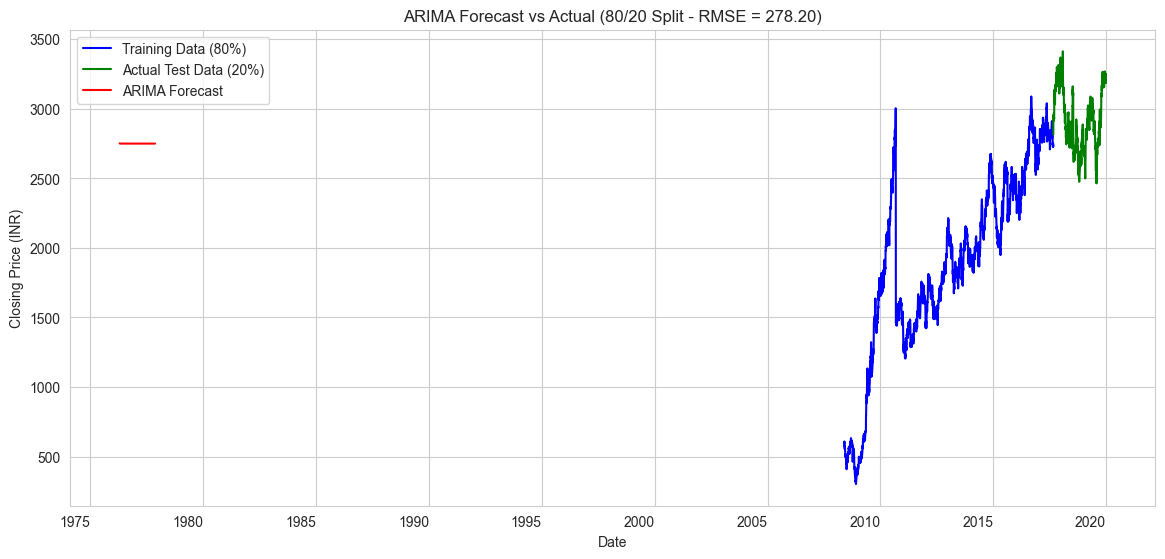

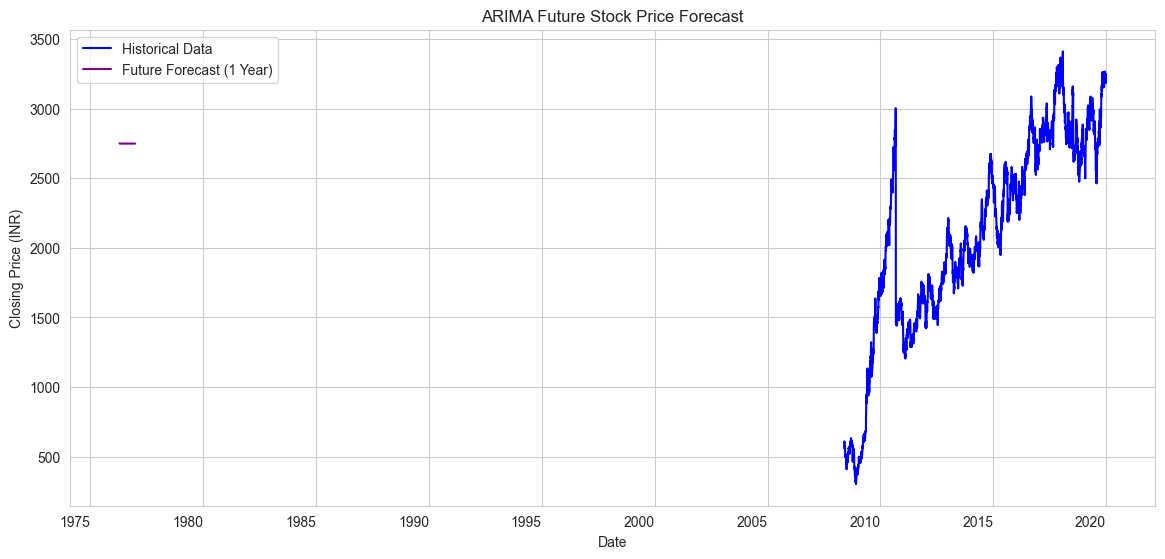


Updated complete!
- Train/Test split: 80/20 as requested
- Model still fast (seconds)
- Larger test set = more realistic evaluation


In [8]:
# 6. Evaluation & Visualization
# ========================
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot forecast vs actual
plt.figure()
train.plot(label='Training Data (80%)', color='blue')
test.plot(label='Actual Test Data (20%)', color='green')
forecast.plot(label='ARIMA Forecast', color='red')
plt.title(f'ARIMA Forecast vs Actual (80/20 Split - RMSE = {rmse:.2f})')
plt.ylabel('Closing Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

# Future forecast (next 252 trading days ~1 year)
future_steps = 252
future_forecast = arima_fit.forecast(steps=future_steps)
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')

plt.figure()
df['Close'].plot(label='Historical Data', color='blue')
future_forecast.plot(label='Future Forecast (1 Year)', color='purple')
plt.title('ARIMA Future Stock Price Forecast')
plt.ylabel('Closing Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

print("\nUpdated complete!")
print("- Train/Test split: 80/20 as requested")
print("- Model still fast (seconds)")
print("- Larger test set = more realistic evaluation")